In [31]:
import os
os.getcwd()
os.chdir('/sdf/home/c/carsmith/icarus-summer-2023')

In [32]:
import numpy as np
import yaml, torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
import pandas as pd
import plotly.graph_objects as go
from ipywidgets import widgets
from ipywidgets import interact
from IPython.display import display

from pfmatch import DataGen
from pfmatch.photonlib.photon_library import PhotonLibrary
from pfmatch.algorithm.match_model import PoissonMatchLoss

## How-to: 1D loss scan

In this notebook we cover a simple example of scanning a loss surface.
1. Generate a single track-flash pair
2. Visualize
3. Scan along the drift direction

### Setup

* Load configurations
* Create two API instances: data generator (which makes a flash-track pair) and loss calculator

In [33]:
# Configurations
det_yaml='data/config/detector_specs.yml'
det_cfg = yaml.load(open(det_yaml), Loader=yaml.Loader)['DetectorSpecs']
gen_yaml='data/config/flashmatch.yml'
gen_cfg = yaml.load(open(gen_yaml), Loader=yaml.Loader)

# Data generator construction
plib = PhotonLibrary('data/plib.h5')
generator = DataGen(det_cfg, gen_cfg, plib)

# Loss calculator
loss_fn = PoissonMatchLoss()

## Data generation

Create a track-shower pair and visualize them.

Flash (PMT v.s. PE)


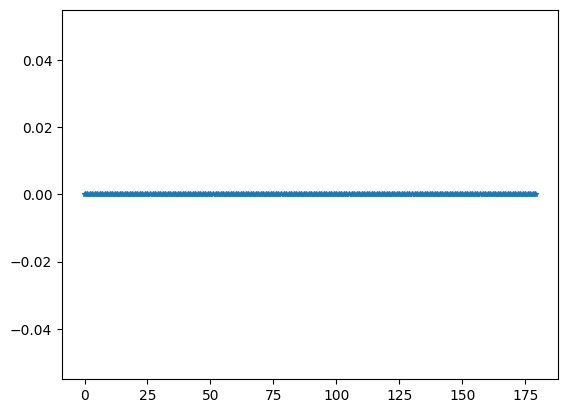

Trajectory 3D points


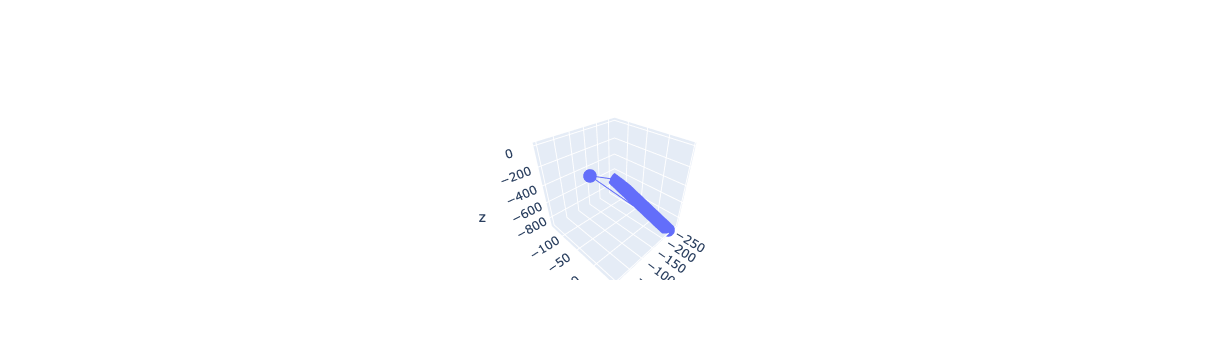

In [34]:
#Generating one flash-match pair of qcluster and flash
pair = generator.make_flashmatch_inputs(1)

# Plot a flash 
print('Flash (PMT v.s. PE)')
truth_flash = pair.flash_v[0]
plt.plot(np.arange(truth_flash.pe_v.shape[0]),truth_flash.pe_v.cpu().numpy(),marker='*',markersize=4)
plt.show()

# Visualize a Track
print('Trajectory 3D points')
qc = pair.qcluster_v[0]
pts=qc.qpt_v.cpu().numpy()
trace=go.Scatter3d(x=pts[:,0],y=pts[:,1],z=pts[:,2])
fig=go.Figure()
fig.add_trace(trace)
fig.show()

## Loss calculation

In [35]:
#Flash hypothesis from shifted qcluster
hypothesis = generator.make_flash(qc)

#Loss
loss0 = loss_fn(hypothesis.pe_v, truth_flash.pe_v)

print('Loss:',loss0.item())

Loss: 9.182741114e-315


## Loss scan

Now let the trajectory shift along the x-axis and compute the loss value.

In [36]:
#True boundary values for all axes
qc_xmin = qc.qpt_v[:,0].min().item()
qc_xmax = qc.qpt_v[:,0].max().item()

qc_ymin = qc.qpt_v[:,1].min().item()
qc_ymax = qc.qpt_v[:,1].max().item()

qc_zmin = qc.qpt_v[:,2].min().item()
qc_zmax = qc.qpt_v[:,2].max().item()

#Active volume bounds for all axes
active_xmin = det_cfg['ActiveVolumeMin'][0]
active_xmax = det_cfg['ActiveVolumeMax'][0]

active_ymin = det_cfg['ActiveVolumeMin'][1]
active_ymax = det_cfg['ActiveVolumeMax'][1]

active_zmin = det_cfg['ActiveVolumeMin'][2]
active_zmax = det_cfg['ActiveVolumeMax'][2]

shift_init  = qc_xmin - active_xmin
shift_total = (active_xmax - active_xmin) - (qc_xmax - qc_xmin)

shift_y_init  = qc_ymin - active_ymin
shift_y_total = (active_ymax - active_ymin) - (qc_ymax - qc_ymin)

shift_z_init  = qc_zmin - active_zmin
shift_z_total = (active_zmax - active_zmin) - (qc_zmax - qc_zmin)

NSTEPS_X = 100 # number of samples along x axis
dx = shift_total/NSTEPS_X

NSTEPS_Y = 100 # number of samples along x axis
dy = shift_y_total/NSTEPS_Y

NSTEPS_Z = 100 # number of samples along x axis
dz = shift_z_total/NSTEPS_Z

In [37]:
# Step1, record the true boundary x values that include the trajectory
print('The trajectory spans X:',qc_xmin,'=>',qc_xmax)

# Step2, get the active volume bounds along the x-axis
print('The active volume spans X:',active_xmin,'=>',active_xmax)

# Step3, figure out the shift.
# 1. calculate the lowest x position to shift (where the tracjectory touches the active volume minimum)
# 2. calculate the highest x position to shift (where the trajectory touches the active volume maximum)
print('Will shift the x-position of the trajectory by:', shift_init)
print('Then move the trajectory up to:', shift_total)

# Step4, scan the loss value
NSTEPS_X = 100 # number of samples along x axis
dx = shift_total/NSTEPS_X # the step size to move the trajectory along x
loss_v=[] # a list to store the computed loss values in the loop below

# Apply the initial shift
qc.qpt_v[:,0] -= shift_init
# Loop over NSTEPS, apply dx, compute the loss
for i in range(NSTEPS_X):
    # shift
    qc.qpt_v[:,0] += dx
    #Flash hypothesis from shifted qcluster
    hypothesis = generator.make_flash(qc)
    #Loss
    loss = loss_fn(hypothesis.pe_v, truth_flash.pe_v)
    loss_v.append(loss.cpu().item())

#Resetting shift in x
qc.qpt_v[:, 0] -= shift_total

The trajectory spans X: 2e-323 => 0.0
The active volume spans X: -358.49 => -61.94
Will shift the x-position of the trajectory by: 358.49
Then move the trajectory up to: 296.55


Letting the trajectory shift along the y-axis next.

In [38]:
# Step1, record the true boundary y values that include the trajectory
print('The trajectory spans Y:',qc_ymin,'=>',qc_ymax)

# Step2, get the active volume bounds along the x-axis
print('The active volume spans Y:',active_ymin,'=>',active_ymax)

# Step3, figure out the shift.
# 1. calculate the lowest y position to shift (where the tracjectory touches the active volume minimum)
# 2. calculate the highest y position to shift (where the trajectory touches the active volume maximum)
print('Will shift the y-position of the trajectory by:', shift_y_init)
print('Then move the trajectory up to:', shift_y_total)

# Step 4, scan the loss value
NSTEPS_Y = 100 # number of samples along x axis
dy = shift_y_total/NSTEPS_Y # the step size to move the trajectory along y
loss_y_v=[] # a list to store the computed loss values in the loop below

# Apply the initial shift
qc.qpt_v[:,1] -= shift_y_init
# Loop over NSTEPS, apply dy, compute the loss
for i in range(NSTEPS_Y):
    # shift
    qc.qpt_v[:,1] += dy
    #Flash hypothesis from shifted qcluster
    hypothesis = generator.make_flash(qc)
    #Loss
    loss = loss_fn(hypothesis.pe_v, truth_flash.pe_v)
    loss_y_v.append(loss.cpu().item())
    
#Resetting shift in y
qc.qpt_v[:, 1] -= shift_y_total

The trajectory spans Y: 0.0 => 0.0
The active volume spans Y: -181.86 => 134.96
Will shift the y-position of the trajectory by: 181.86
Then move the trajectory up to: 316.82000000000005


Letting the trajectory shift along the z-axis

In [39]:
# Step1, record the true boundary z values that include the trajectory
print('The trajectory spans Z:',qc_zmin,'=>',qc_zmax)

# Step2, get the active volume bounds along the z-axis
print('The active volume spans Z:',active_zmin,'=>',active_zmax)

# Step3, figure out the shift.
# 1. calculate the lowest z position to shift (where the tracjectory touches the active volume minimum)
# 2. calculate the highest z position to shift (where the trajectory touches the active volume maximum)
print('Will shift the z-position of the trajectory by:', shift_z_init)
print('Then move the trajectory up to:', shift_z_total)

# Step4, scan the loss value
NSTEPS_Z = 100 # number of samples along x axis
dz = shift_z_total/NSTEPS_Z # the step size to move the trajectory along z
loss_z_v=[] # a list to store the computed loss values in the loop below

# Apply the initial shift
qc.qpt_v[:,2] -= shift_z_init
# Loop over NSTEPS, apply dz, compute the loss
for i in range(NSTEPS_Z):
    # shift
    qc.qpt_v[:,2] += dz
    #Flash hypothesis from shifted qcluster
    hypothesis = generator.make_flash(qc)
    #Loss
    loss = loss_fn(hypothesis.pe_v, truth_flash.pe_v)
    loss_z_v.append(loss.cpu().item())

#Resetting shift in z
qc.qpt_v[:, 2] -= shift_z_total

The trajectory spans Z: 0.0 => 0.0
The active volume spans Z: -894.951 => 894.951
Will shift the z-position of the trajectory by: 894.951
Then move the trajectory up to: 1789.902


## Plot the loss

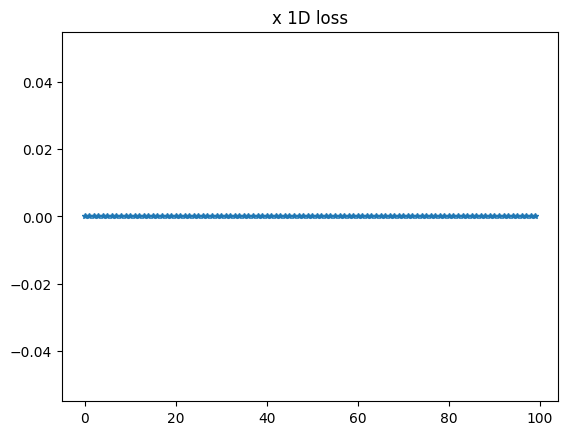

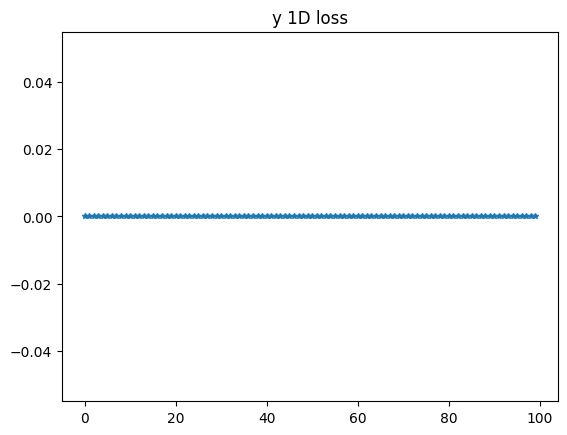

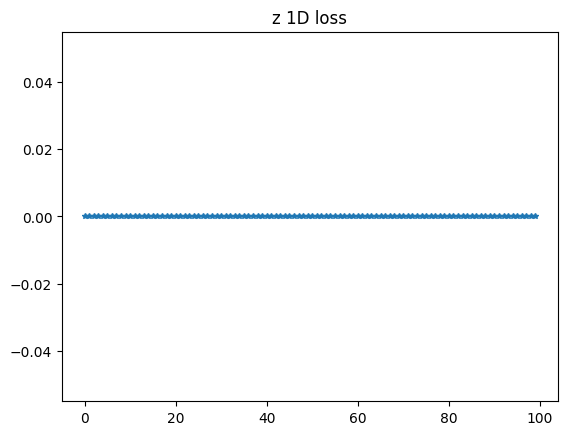

In [40]:
plt.plot(np.arange(len(loss_v)),loss_v,marker='*',markersize=4)
plt.title("x 1D loss")
plt.show()

plt.plot(np.arange(len(loss_y_v)),loss_y_v,marker='*',markersize=4)
plt.title("y 1D loss")
plt.show()

plt.plot(np.arange(len(loss_z_v)),loss_z_v,marker='*',markersize=4)
plt.title("z 1D loss")
plt.show()

## Scanning a 2D loss surface in the x-y plane

In [41]:
df = pd.DataFrame(columns = ["x", "y", "loss"])

import warnings
warnings.filterwarnings("ignore")

#Applying initial shift in x - not needed if resetting to initial shift after 1d plots
#qc.qpt_v[:,0] -= shift_init

# Loop over NSTEPS, apply dx, compute the loss
for i in range(NSTEPS_X):
    # shift in x
    qc.qpt_v[:,0] += dx
    
    #initial shift in y - see above
    for j in range(NSTEPS_Y):
        #shift in y
        qc.qpt_v[:,1] += dy
        
        #Flash hypothesis from shifted qcluster
        hypothesis = generator.make_flash(qc)
        
        #Loss
        loss = loss_fn(hypothesis.pe_v, truth_flash.pe_v)
        new_row = pd.DataFrame({"x": [i*dx + active_xmin], "y": [j*dy + active_ymin], "loss": [loss.cpu().item()]})
        df = pd.concat([df, new_row], ignore_index = True)
        
#Resetting shifts
qc.qpt_v[:, 0] -= shift_total
qc.qpt_v[:, 1] -= shift_y_total

In [42]:
#Creating an interactive 2D plot
def create_scatter_plot(elevation, azimuth):
    scatter_plot = go.FigureWidget(
        data=[
            go.Scatter3d(
                x=df['x'], y=df['y'], z=df['loss'],
                mode='markers',
                marker=dict(size=5, color=df['loss'], colorscale='Viridis'),
            )
        ],
        layout=go.Layout(scene=dict(aspectmode='cube', zaxis_title = "loss"), title="Loss Surface for shifting in x-y plane"),
    )

    scatter_plot.update_layout(scene=dict(camera=dict(eye=dict(x=azimuth, y=elevation, z=1))))

    return scatter_plot

# Create interactive widgets
elevation_slider = widgets.FloatSlider(value=30, min=0, max=90, step=1, description='Elevation')
azimuth_slider = widgets.FloatSlider(value=45, min=0, max=360, step=1, description='Azimuth')

# Create interactive controls using ipywidgets
interactive_plot = interact(create_scatter_plot, elevation=elevation_slider, azimuth=azimuth_slider)

# Display the interactive plot
display(interactive_plot)

interactive(children=(FloatSlider(value=30.0, description='Elevation', max=90.0, step=1.0), FloatSlider(value=…

<function __main__.create_scatter_plot(elevation, azimuth)>

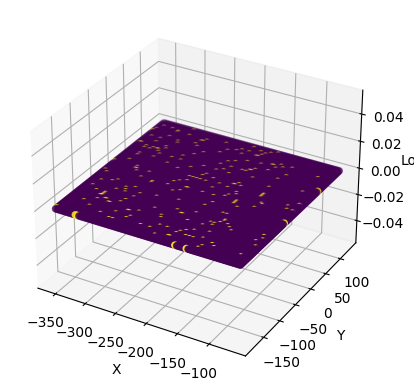

In [43]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x, y, z = df.iloc[:, 0], df.iloc[:, 1], df.iloc[:, 2]

ax.scatter(df.iloc[:, 0], df.iloc[:, 1], df.iloc[:, 2], c=df.iloc[:, 2], cmap='viridis', marker='o')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Loss')
plt.show()

In [44]:
#Resetting shifts
qc.qpt_v[:, 0] -= shift_total
qc.qpt_v[:, 2] -= shift_z_total

df2 = pd.DataFrame(columns = ["x", "z", "loss"])

import warnings
warnings.filterwarnings("ignore")

#Applying initial shift in x - not needed if resetting to initial shift after 1d plots
#qc.qpt_v[:,0] -= shift_init

# Loop over NSTEPS, apply dx, compute the loss
for i in range(NSTEPS_X):
    # shift in x
    qc.qpt_v[:,0] += dx
    
    #initial shift in y - see above
    for j in range(NSTEPS_Y):
        #shift in y
        qc.qpt_v[:,2] += dz
        
        #Flash hypothesis from shifted qcluster
        hypothesis = generator.make_flash(qc)
        
        #Loss
        loss = loss_fn(hypothesis.pe_v, truth_flash.pe_v)
        new_row = pd.DataFrame({"x": [i*dx + active_xmin], "z": [j*dz + active_zmin], "loss": [loss.cpu().item()]})
        df2 = pd.concat([df2, new_row], ignore_index = True)

In [45]:
#Creating an interactive 2D plot
def create_scatter_plot(elevation, azimuth):
    scatter_plot = go.FigureWidget(
        data=[
            go.Scatter3d(
                x=df2['x'], y=df2['z'], z=df2['loss'],
                mode='markers',
                marker=dict(size=5, color=df2['loss'], colorscale='Viridis'),
            )
        ],
        layout=go.Layout(scene=dict(aspectmode='cube', zaxis_title = "loss"), title="Loss Surface for shifting in x-y plane"),
    )

    scatter_plot.update_layout(scene=dict(camera=dict(eye=dict(x=azimuth, y=elevation, z=1))))

    return scatter_plot

# Create interactive widgets
elevation_slider = widgets.FloatSlider(value=30, min=0, max=90, step=1, description='Elevation')
azimuth_slider = widgets.FloatSlider(value=45, min=0, max=360, step=1, description='Azimuth')

# Create interactive controls using ipywidgets
interactive_plot = interact(create_scatter_plot, elevation=elevation_slider, azimuth=azimuth_slider)

# Display the interactive plot
display(interactive_plot)

interactive(children=(FloatSlider(value=30.0, description='Elevation', max=90.0, step=1.0), FloatSlider(value=…

<function __main__.create_scatter_plot(elevation, azimuth)>